In [1]:
# Import the relevant tools
import time                 # to measure performance
import numpy as np          # standard array library
import torch
from   torch.autograd import Variable
import torch.optim as optim


# No need for a ~/.theanorc file anymore !
use_cuda = torch.cuda.is_available()
dtype     = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
dtypeint = torch.cuda.LongTensor  if use_cuda else torch.LongTensor
# Display routines :
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.collections  import LineCollection


# Input/Output routines =========================================================================
# from '.vtk' to Curves objects  ----------------------------------------------------------------
from pyvtk import VtkData
# from '.png' to level curves  ------------------------------------------------------------------
from skimage.measure import find_contours
from scipy import misc
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import imageio


In [3]:

def arclength_param(line) :
	"Arclength parametrisation of a piecewise affine curve."
	vel = line[1:, :] - line[:-1, :]     # γ̇(t)
	vel = np.sqrt(np.sum( vel ** 2, 1 )) # arclength = |γ̇(t)|^2
	return np.hstack( ( [0], np.cumsum( vel, 0 ) ) )


def arclength(line) :
	"Total length of a piecewise affine curve."
	return arclength_param(line)[-1]

	
def resample(line, npoints) :
	"Resamples a curve by arclength through linear interpolation."
	s = arclength_param(line)
	f = interp1d(s, line, kind = 'linear', axis = 0, assume_sorted = True)
	
	p = f( np.linspace(0, s[-1], npoints) )
	connec = np.vstack( (np.arange(0, len(p) - 1), 
						 np.arange(1, len(p)    )) ).T
	if np.array_equal(p[0], p[-1]) : # i.e. p is a loop
		p = p[:-1]
		connec = np.vstack( (connec[:-1,:],  [len(p)-1, 0]) )
        
    # (npoints, 2), (npionts, 2): X, E (edges)
	return (p, connec)


def level_curves(fname, npoints = 200, smoothing = 10, level = 0.5) :
	"Loads regularly sampled curves from a .PNG image."
	# Find the contour lines
	img = imageio.imread(fname, as_gray = True) # Grayscale
	img = (img.T[:, ::-1])  / 255.
# 	img = img/255.
	img = gaussian_filter(img, smoothing, mode='nearest')
	lines = find_contours(img, level)

	# Compute the sampling ratio for every contour line
	lengths = np.array( [arclength(line) for line in lines] )
	points_per_line = np.ceil( npoints * lengths / np.sum(lengths) ).astype(np.int)
	
	# Interpolate accordingly
	points = [] ; connec = [] ; index_offset = 0
	for ppl, line in zip(points_per_line, lines) :
		(p, c) = resample(line, ppl)
		points.append(p)
		connec.append(c + index_offset)
		index_offset += len(p)

#     fig,ax = plt.subplots(1,1,figsize=(10,10))
#     ax.imshow(img)
#     for i, line in enumerate(lines):
#         ax.scatter(lines[i][:,1], lines[i][:,0])
#         (p, c) = resample(lines[i], points_per_line[i])
#         ax.scatter(p[:,1], p[:,0])
	
	size   = np.maximum(img.shape[0], img.shape[1])
	points = np.vstack(points) / size
	connec = np.vstack(connec)
	return Curve(points, connec)


f1_name = 'data/amoeba_1.png'
curve = level_curves(f1_name)
center, length = curve.to_measure()


color = 'rainbow'
linewidth = 3

segs = curve.segments()

ncycles    = 5
cNorm      = colors.Normalize(vmin=0, vmax=(len(segs)-1)/ncycles)
scalarMap  = cm.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('hsv') )
seg_colors = [ scalarMap.to_rgba( i % ((len(segs)-1)/ncycles) ) 
               for i in range(len(segs)) ]

# segs = np.stack((segs[:,:,1], segs[:,:,0]),axis=2)
segs = segs.transpose((0,2,1))
print(segs.shape)
line_segments = LineCollection(segs, linewidths=(linewidth,), 
                               colors=seg_colors, linestyle='solid')

# curve.plot(ax)
img = imageio.imread(f1_name, as_gray = True) # Grayscale
img = img / 255.
# img = (img.T[:, ::-1])  / 255.
# img = img.T[:,::-1]/255.

# img = imageio.imread('https://raw.githubusercontent.com/imageio/imageio-binaries/master/images/astronaut.png')
# img = (img.T[:, ::-1,:])  / 255.

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img)
for i, line in enumerate(lines):
    ax.scatter(lines[i][:,1], lines[i][:,0])


NameError: name 'Curve' is not defined

In [22]:

# Pyplot Output =================================================================================

def GridData() :
	"Returns the coordinates and connectivity of the grid carried along by a deformation."
	nlines = 11 ; ranges = [ (0,1), (0,1) ] # one square = (.1,.1)
	np_per_lines = (nlines-1) * 4 + 1       # Supsample lines to get smooth figures
	x_l = [np.linspace(min_r, max_r, nlines      ) for (min_r,max_r) in ranges]
	x_d = [np.linspace(min_r, max_r, np_per_lines) for (min_r,max_r) in ranges]
	
	v = [] ; c = [] ; i = 0
	for x in x_l[0] :                    # One vertical line per x :
		v += [ [x, y] for y in x_d[1] ]  # Add points to the list of vertices.
		c += [ [i+j,i+j+1] for j in range(np_per_lines-1)] # + appropriate connectivity
		i += np_per_lines
	for y in x_l[1] :                    # One horizontal line per y :
		v += [ [x, y] for x in x_d[1] ]  # Add points to the list of vertices.
		c += [ [i+j,i+j+1] for j in range(np_per_lines-1)] # + appropriate connectivity
		i += np_per_lines
	
	return ( np.vstack(v), np.vstack(c) ) # (vertices, connectivity)
	
def ShowTransport( Q, Xt, Gamma, ax ) :
	"Displays a transport plan."
	points = [] ; connectivity = [] ; curr_id = 0
	Q_points,Q_weights = Q.to_measure()  ;  xtpoints = Xt.points # Extract the centers + areas
	for (a, mui, gi) in zip(Q_points, Q_weights, Gamma) :
		gi = gi / mui # gi[j] = fraction of the mass from "a" which goes to xtpoints[j]
		for (seg, gij) in zip(Xt.connectivity, gi) :
			mass_per_line = 0.05
			if gij >= mass_per_line :
				nlines = np.floor(gij / mass_per_line).astype(np.int)
				ts     = np.linspace(.35, .65, nlines)
				for t in ts :
					b = (1-t) * xtpoints[seg[0]] + t * xtpoints[seg[1]]
					points += [a, b]; connectivity += [[curr_id, curr_id + 1]]; curr_id += 2
	if len(connectivity) > 0 :
		Plan = Curve(np.vstack(points), np.vstack(connectivity))
		Plan.plot(ax, color = (.6,.8,1.), linewidth = 1)

def DisplayShoot(Q0, G0, p0, Q1, G1, Xt, info, it, scale_momentum, scale_attach) :
	"Displays a pyplot Figure and save it."
	import os
	os.makedirs('output', exist_ok=True)
	# Figure at "t = 0" : -----------------------------------------------------------------------
	fig = plt.figure(1, figsize = (10,10), dpi=100); fig.clf(); ax = fig.add_subplot(1, 1, 1)
	ax.autoscale(tight=True)
	
	G0.plot(ax, color = (.8,.8,.8), linewidth = 1)
	Xt.plot(ax, color = (.85, .6, 1.))
	Q0.plot(ax)
	
	ax.quiver( Q0.points[:,0], Q0.points[:,1], p0[:,0], p0[:,1], 
	           scale = scale_momentum, color='blue')
	
	ax.axis([0, 1, 0, 1]) ; ax.set_aspect('equal') ; plt.draw() ; plt.pause(0.001)
	fig.savefig( 'output/momentum_' + str(it) + '.png' )
	
	# Figure at "t = 1" : -----------------------------------------------------------------------
	fig = plt.figure(2, figsize = (10,10), dpi=100); fig.clf(); ax = fig.add_subplot(1, 1, 1)
	ax.autoscale(tight=True)
	if scale_attach == 0 : # Convenient way of saying that we're using a transport plan.
		ShowTransport( Q1, Xt, info, ax)
	else :                 # Otherwise, it's a kernel matching term.
		ax.imshow(info, interpolation='bilinear', origin='lower', 
				vmin = -scale_attach, vmax = scale_attach, cmap=cm.RdBu, 
				extent=(0,1, 0, 1)) 
	G1.plot(ax, color = (.8,.8,.8), linewidth = 1)
	Xt.plot(ax, color = (.76, .29, 1.))
	Q1.plot(ax)
	
	ax.axis([0, 1, 0, 1]) ; ax.set_aspect('equal') ; plt.draw() ; plt.pause(0.001)
	fig.savefig( 'output/model_' + str(it) + '.png' )
    
    

(198, 2)


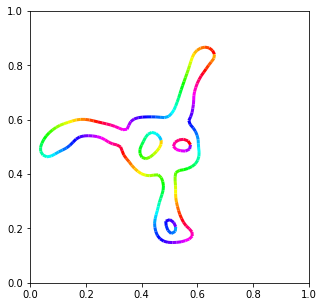

In [8]:

# Curve representations =========================================================================

class Curve :
	"Encodes a 2D curve as an array of float coordinates + a connectivity list."
	def __init__(self, points, connectivity) :
		"points should be a n-by-2 float array, connectivity an nsegments-by-2 int array." 
		self.points       = points
		self.connectivity = connectivity
	
	def segments(self) :
		"Returns the list of segments the curve is made of."
		return np.array( [  [self.points[l[0]], self.points[l[1]]] for l in self.connectivity ] )
		
	def to_measure(self) :
		"""
		Outputs the sum-of-diracs measure associated to the curve.
		Each segment from the connectivity matrix self.c
		is represented as a weighted dirac located at its center,
		with weight equal to the segment length.
		"""
		segments = self.segments()
		centers = [         .5 * (  seg[0] + seg[1]      ) for seg in segments ]
		lengths = [np.sqrt(np.sum( (seg[1] - seg[0])**2 )) for seg in segments ]
		return ( np.array(centers), np.array(lengths) )
	
	@staticmethod
	def _vertices_to_measure( q, connec ) :
		"""
		Transforms a torch array 'q1' into a measure, assuming a connectivity matrix connec.
		It is the Torch equivalent of 'to_measure'.
		"""
		a = q[connec[:,0]] ; b = q[connec[:,1]]
		# A curve is represented as a sum of diracs, one for each segment
		x  = .5 * (a + b)                     # Mean
		mu = torch.sqrt( ((b-a)**2).sum(1) )  # Length
		return (x, mu)
		
	def plot(self, ax, color = 'rainbow', linewidth = 3) :
		"Simple display using a per-id color scheme."
		segs = self.segments()
		
		if color == 'rainbow' :   # rainbow color scheme to see pointwise displacements
			ncycles    = 5
			cNorm      = colors.Normalize(vmin=0, vmax=(len(segs)-1)/ncycles)
			scalarMap  = cm.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('hsv') )
			seg_colors = [ scalarMap.to_rgba( i % ((len(segs)-1)/ncycles) ) 
			               for i in range(len(segs)) ]
		else :                    # uniform color
			seg_colors = [ color for i in range(len(segs)) ] 
		
# 		segs = np.stack((segs[:,:,1], segs[:,:,0]), axis=2)
		line_segments = LineCollection(segs, linewidths=(linewidth,), 
		                               colors=seg_colors, linestyle='solid')
		ax.add_collection(line_segments)
		
	@staticmethod
	def from_file(fname, **kwargs) :
		if   fname[-4:] == '.png' :
			return level_curves(fname, **kwargs)
		elif fname[-4:] == '.vtk' :
			data = VtkData(fname)
			points = np.array(data.structure.points)[:,0:2] # Discard "Z"
			connec = np.array(data.structure.polygons)
			return Curve((points + 150)/300, connec) # offset for the skull dataset...
			

f1_name = 'data/amoeba_1.png'
f2_name = 'data/amoeba_2.png'
c = Curve.from_file(f1_name)
fig,ax = plt.subplots(1,1,figsize=(5,5))
c.plot(ax)
print(c.points.shape)

In [31]:

def _squared_distances(x, y) :
	"Returns the matrix of $\|x_i-y_j\|^2$."
	x_col = x.unsqueeze(1) # Theano : x.dimshuffle(0, 'x', 1)
	y_lin = y.unsqueeze(0) # Theano : y.dimshuffle('x', 0, 1)
	return torch.sum( (x_col - y_lin)**2 , 2 )

# def _k(x, y, s) :
# 	"Returns the matrix of k(x_i,y_j)."
# 	sq = _squared_distances(x, y) / (s**2)
# 	#return torch.exp( -sq )
# 	return torch.pow( 1. / ( 1. + sq ), .25 )

# def _k(x, y, ℓ):
#     sq = _squared_distances(x/ℓ, y/ℓ)
#     return torch.exp(-sq/2)

def _k(x, y, ℓ):
    sq = _squared_distances(x, y)
    return 1*torch.exp(-sq/2/(.025)**2) + .75*torch.exp(-sq/2/(.15)**2)


def _cross_kernels(q, x, s) :
	"Returns the full k-correlation matrices between two point clouds q and x."
	K_qq = _k(q, q, s)
	K_qx = _k(q, x, s)
	K_xx = _k(x, x, s)
	return (K_qq, K_qx, K_xx)

def _Hqp(q, p, sigma) :
	"The hamiltonian, or kinetic energy of the shape q with momenta p."
	pKqp =  _k(q, q, sigma) * (p @ p.t()) # Use a simple isotropic kernel
	return .5 * pKqp.sum()                # $H(q,p) = \frac{1}{2} * sum_{i,j} k(x_i,x_j) p_i.p_j$
    
    
# Part 2 : Geodesic shooting ====================================================================
# The partial derivatives of the Hamiltonian are automatically computed !
def _dq_Hqp(q,p,sigma) : 
	return torch.autograd.grad(_Hqp(q,p,sigma), q, create_graph=True)[0]
def _dp_Hqp(q,p,sigma) :
	return torch.autograd.grad(_Hqp(q,p,sigma), p, create_graph=True)[0]

def _hamiltonian_step(q,p, sigma) :
	"Simplistic euler scheme step with dt = .1."
	return [q + .1 * _dp_Hqp(q,p,sigma) ,  # See eq. 
			p - .1 * _dq_Hqp(q,p,sigma) ]

def _HamiltonianShooting(q, p, sigma) :
	"Shoots to time 1 a k-geodesic starting (at time 0) from q with momentum p."
	for t in range(10) :
		q,p = _hamiltonian_step(q, p, sigma) # Let's hardcode the "dt = .1"
	return [q,p]                             # and only return the final state + momentum


# Part 2bis : Geodesic shooting + deformation of the ambient space, for visualization ===========
def _HamiltonianCarrying(q, p, g, s) :
	"""
	Similar to _HamiltonianShooting, but also conveys information about the deformation of
	an arbitrary point cloud 'grid' in the ambient space.
	""" 
	for t in range(10) : # Let's hardcode the "dt = .1"
		q,p,g = [q + .1 * _dp_Hqp(q,p, s), 
		         p - .1 * _dq_Hqp(q,p, s), 
		         g + .1 * _k(g, q, s) @ p]
	return q,p,g         # return the final state + momentum + grid


# Part 3 : Data attachment ======================================================================

def _ot_matching(q1_x, q1_mu, xt_x, xt_mu, radius) :
	"""
	Given two measures q1 and xt represented by locations/weights arrays, 
	outputs an optimal transport fidelity term and the transport plan.
	"""
	# The Sinkhorn algorithm takes as input three Theano variables :
	c = _squared_distances(q1_x, xt_x) # Wasserstein cost function
	mu = q1_mu ; nu = xt_mu
	
	# Parameters of the Sinkhorn algorithm.
	epsilon            = (.015)**2          # regularization parameter
	rho                = (.5) **2          # unbalanced transport (See PhD Th. of Lenaic Chizat)
	niter              = 10000             # max niter in the sinkhorn loop
	tau                = -.8               # nesterov-like acceleration
	
	lam = rho / (rho + epsilon)            # Update exponent
	
	# Elementary operations .....................................................................
	def ave(u,u1) : 
		"Barycenter subroutine, used by kinetic acceleration through extrapolation."
		return tau * u + (1-tau) * u1 
	def M(u,v)  : 
		"$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
		return (-c + u.unsqueeze(1) + v.unsqueeze(0)) / epsilon
	lse = lambda A    : torch.log(torch.exp(A).sum( 1 ) + 1e-6) # slight modif to prevent NaN
	
	# Actual Sinkhorn loop ......................................................................
	u,v,err = 0.*mu, 0.*nu, 0.
	actual_nits = 0
	
	for i in range(niter) :
		u1= u # useful to check the update
		u = ave( u, lam * ( epsilon * ( torch.log(mu) - lse(M(u,v))   ) + u ) )
		v = ave( v, lam * ( epsilon * ( torch.log(nu) - lse(M(u,v).t()) ) + v ) )
		err = (u - u1).abs().sum()
		
		actual_nits += 1
		if (err < 1e-4).data.cpu().numpy() :
			break
	U, V = u, v 
	Gamma = torch.exp( M(U,V) )            # Eventual transport plan g = diag(a)*K*diag(b)
	cost  = torch.sum( Gamma * c )         # Simplistic cost, chosen for readability in this tutorial
	
	print('Sinkhorn error after ' + str(actual_nits) + ' iterations : ' + str(err.data.cpu().numpy()))
	return [cost, Gamma]
	


def _kernel_matching(q1_x, q1_mu, xt_x, xt_mu, radius) :
	"""
	Given two measures q1 and xt represented by locations/weights arrays, 
	outputs a kernel-fidelity term and an empty 'info' array.
	"""
	K_qq, K_qx, K_xx = _cross_kernels(q1_x, xt_x, radius)
	cost = .5 * (   torch.sum(K_qq * torch.ger(q1_mu,q1_mu)) \
				 +  torch.sum(K_xx * torch.ger(xt_mu,xt_mu)) \
				 -2*torch.sum(K_qx * torch.ger(q1_mu,xt_mu))  )
				 
	# Info = the 2D graph of the blurred distance function
	# Increase res if you want to get nice smooth pictures...
	res    = 10 ; ticks = np.linspace( 0, 1, res + 1)[:-1] + 1/(2*res) 
	X,Y    = np.meshgrid( ticks, ticks )
	points = Variable(torch.from_numpy(np.vstack( (X.ravel(), Y.ravel()) ).T).type(dtype), requires_grad=False)
							   
	info   = _k( points, q1_x , radius ) @ q1_mu \
	       - _k( points, xt_x , radius ) @ xt_mu
	return [cost , info.view( (res,res) ) ]

def _data_attachment(q1_measure, xt_measure, radius) :
	"Given two measures and a radius, returns a cost - as a Theano symbolic variable."
	if radius == 0 : # Convenient way to allow the choice of a method
		return _ot_matching(q1_measure[0], q1_measure[1], 
								xt_measure[0], xt_measure[1], 
								radius)
	else :
		return _kernel_matching(q1_measure[0], q1_measure[1], 
								xt_measure[0], xt_measure[1], 
								radius)
    

# Part 4 : Cost function and derivatives ========================================================

def _cost( q,p, xt_measure, connec, params ) :
	"""
	Returns a total cost, sum of a small regularization term and the data attachment.
	.. math ::
	
		C(q_0, p_0) = .01 * H(q0,p0) + 1 * A(q_1, x_t)
	
	Needless to say, the weights can be tuned according to the signal-to-noise ratio.
	"""
	s,r  = params                        # Deformation scale, Attachment scale
	q1 = _HamiltonianShooting(q,p,s)[0]  # Geodesic shooting from q0 to q1
	# To compute a data attachment cost, we need the set of vertices 'q1' into a measure.
	q1_measure  = Curve._vertices_to_measure( q1, connec ) 
	attach_info = _data_attachment( q1_measure,  xt_measure,  r )
	return [ .01* _Hqp(q, p, s) + 1* attach_info[0] , attach_info[1] ]

# The discrete backward scheme is automatically computed :
def _dcost_p( q,p, xt_measure, connec, params ) :
	"The gradients of C wrt. p_0 is automatically computed."
	return torch.autograd.grad( _cost(q,p, xt_measure, connec, params)[0] , p)

In [32]:

#================================================================================================

def VisualizationRoutine(Q0, params) :
	def ShootingVisualization(q,p,grid) :
		return _HamiltonianCarrying(q, p, grid, params[0])
	return ShootingVisualization

def perform_matching( Q0, Xt, params, scale_momentum = 1, scale_attach = 1) :
	"Performs a matching from the source Q0 to the target Xt, returns the optimal momentum P0."
	(Xt_x, Xt_mu) = Xt.to_measure()      # Transform the target into a measure once and for all
	connec = torch.from_numpy(Q0.connectivity).type(dtypeint) ; 
	# Compilation -------------------------------------------------------------------------------
	# Cost is a function of 6 parameters :
	# The source 'q',                    the starting momentum 'p',
	# the target points 'xt_x',          the target weights 'xt_mu',
	# the deformation scale 'sigma_def', the attachment scale 'sigma_att'.
	q0    = Variable(torch.from_numpy(    Q0.points ).type(dtype), requires_grad=True)
	p0    = Variable(torch.from_numpy( 0.*Q0.points ).type(dtype), requires_grad=True )
	Xt_x  = Variable(torch.from_numpy( Xt_x         ).type(dtype), requires_grad=False)
	Xt_mu = Variable(torch.from_numpy( Xt_mu        ).type(dtype), requires_grad=False)
	
	# Compilation. Depending on settings specified in the ~/.theanorc file or explicitely given
	# at execution time, this will produce CPU or GPU code under the hood.
	def Cost(q,p, xt_x,xt_mu) : 
		return _cost( q,p, (xt_x,xt_mu), connec, params )
		#return [   _cost( q,p, (xt_x,xt_mu), Q0.connectivity, params )[0], 
		#		_dcost_p( q,p, (xt_x,xt_mu), Q0.connectivity, params )   ,
		#		   _cost( q,p, (xt_x,xt_mu), Q0.connectivity, params )[1] ]
							
	# Display pre-computing ---------------------------------------------------------------------
	g0,cgrid = GridData() ; G0 = Curve(g0, cgrid )
	g0 = Variable( torch.from_numpy( g0 ).type(dtype), requires_grad = False )
	# Given q0, p0 and grid points grid0 , outputs (q1,p1,grid1) after the flow
	# of the geodesic equations from t=0 to t=1 :
	ShootingVisualization = VisualizationRoutine(q0, params) 
	
	# L-BFGS minimization -----------------------------------------------------------------------
	from scipy.optimize import minimize
	def matching_problem(p0) :
		"Energy minimized in the variable 'p0'."
		[c, info] = Cost(q0, p0, Xt_x, Xt_mu)
		
		matching_problem.Info = info
		if (matching_problem.it % 20 == 0):# and (c.data.cpu().numpy()[0] < matching_problem.bestc):
			matching_problem.bestc = c.data.cpu().numpy()[0]
			q1,p1,g1 = ShootingVisualization(q0, p0, g0)
			
			q1 = q1.data.cpu().numpy()
			p1 = p1.data.cpu().numpy()
			g1 = g1.data.cpu().numpy()
			
			Q1 = Curve(q1, connec) ; G1 = Curve(g1, cgrid )
			DisplayShoot( Q0, G0,       p0.data.cpu().numpy(), 
			              Q1, G1, Xt, info.data.cpu().numpy(),
			              matching_problem.it, scale_momentum, scale_attach)
		
		print('Iteration : ', matching_problem.it, ', cost : ', c.data.cpu().numpy(), 
		                                            ' info : ', info.data.cpu().numpy().shape)
		matching_problem.it += 1
		return c
	matching_problem.bestc = np.inf ; matching_problem.it = 0 ; matching_problem.Info = None
	
	optimizer = torch.optim.LBFGS(
					[p0],
					max_iter = 1000, 
					tolerance_change = .000001, 
					history_size = 10)
	#optimizer = torch.optim.Adam(
	#				[p0])
	time1 = time.time()
	def closure():
		optimizer.zero_grad()
		c = matching_problem(p0)
		c.backward()
		return c
	for it in range(100) :
		optimizer.step(closure)
	time2 = time.time()
	return p0, matching_problem.Info

def matching_demo(source_file, target_file, params, scale_mom = 1, scale_att = 1) :
	Q0 = Curve.from_file(source_file) # Load source...
	Xt = Curve.from_file(target_file) # and target.
	
	# Compute the optimal shooting momentum :
	p0, info = perform_matching( Q0, Xt, params, scale_mom, scale_att) 

Sinkhorn error after 348 iterations : 9.867977e-05


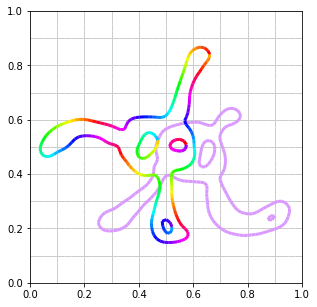

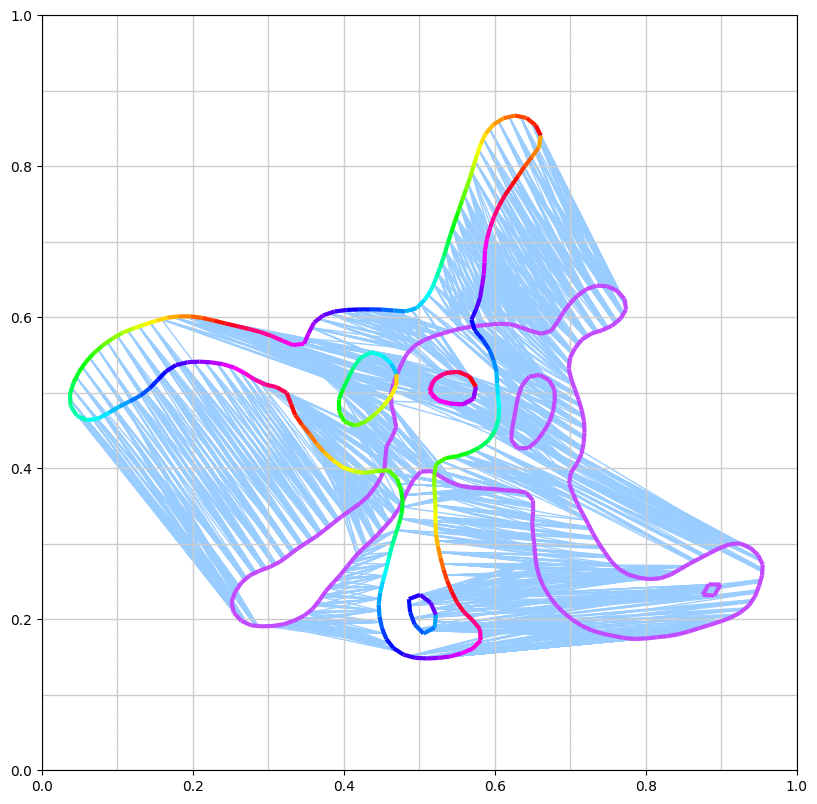

Iteration :  0 , cost :  0.115755685  info :  (198, 198)
Sinkhorn error after 391 iterations : 9.9507626e-05
Iteration :  1 , cost :  0.04804101  info :  (198, 198)
Sinkhorn error after 404 iterations : 9.986042e-05
Iteration :  2 , cost :  0.028693965  info :  (198, 198)
Sinkhorn error after 389 iterations : 9.863263e-05
Iteration :  3 , cost :  0.015749656  info :  (198, 198)
Sinkhorn error after 355 iterations : 9.981659e-05
Iteration :  4 , cost :  0.01068105  info :  (198, 198)
Sinkhorn error after 358 iterations : 9.9311816e-05
Iteration :  5 , cost :  0.008223165  info :  (198, 198)
Sinkhorn error after 366 iterations : 9.961985e-05
Iteration :  6 , cost :  0.007453347  info :  (198, 198)
Sinkhorn error after 373 iterations : 9.8806806e-05
Iteration :  7 , cost :  0.00642524  info :  (198, 198)
Sinkhorn error after 380 iterations : 9.9407276e-05
Iteration :  8 , cost :  0.0055907797  info :  (198, 198)
Sinkhorn error after 383 iterations : 9.8968856e-05
Iteration :  9 , cost :  

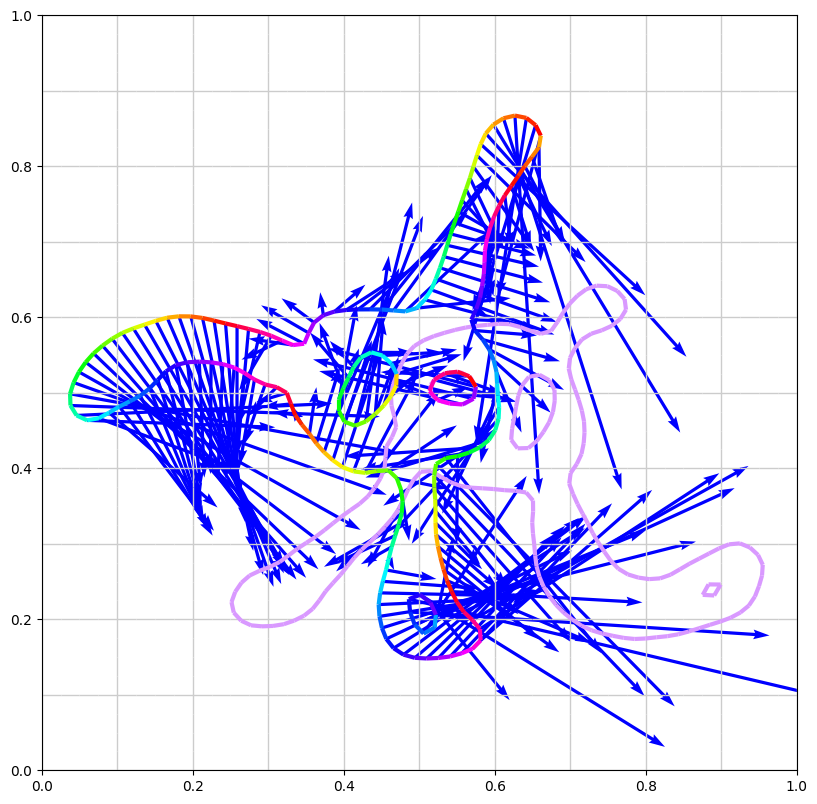

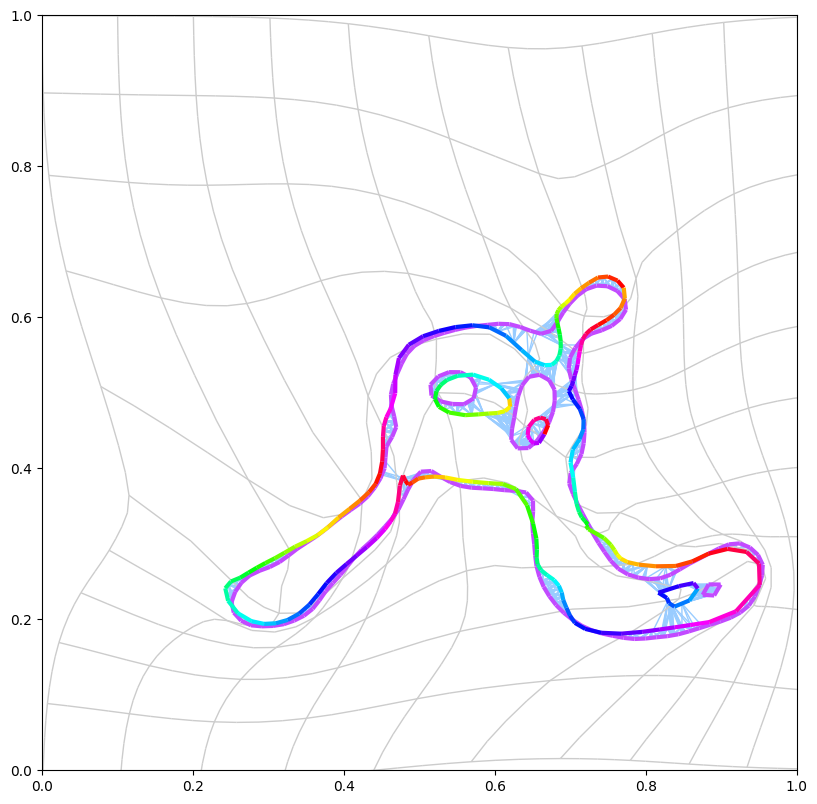

Iteration :  20 , cost :  0.0027451967  info :  (198, 198)
Sinkhorn error after 324 iterations : 9.979159e-05
Iteration :  21 , cost :  0.0027290238  info :  (198, 198)
Sinkhorn error after 321 iterations : 9.85931e-05
Iteration :  22 , cost :  0.0026850596  info :  (198, 198)
Sinkhorn error after 321 iterations : 9.899758e-05
Iteration :  23 , cost :  0.0026584943  info :  (198, 198)
Sinkhorn error after 325 iterations : 9.981965e-05
Iteration :  24 , cost :  0.0026216204  info :  (198, 198)
Sinkhorn error after 336 iterations : 9.960192e-05
Iteration :  25 , cost :  0.0026537555  info :  (198, 198)
Sinkhorn error after 331 iterations : 9.9291094e-05
Iteration :  26 , cost :  0.0025833729  info :  (198, 198)
Sinkhorn error after 331 iterations : 9.870503e-05
Iteration :  27 , cost :  0.0025750722  info :  (198, 198)
Sinkhorn error after 330 iterations : 9.977573e-05
Iteration :  28 , cost :  0.0025647571  info :  (198, 198)
Sinkhorn error after 329 iterations : 9.8893244e-05
Iteration

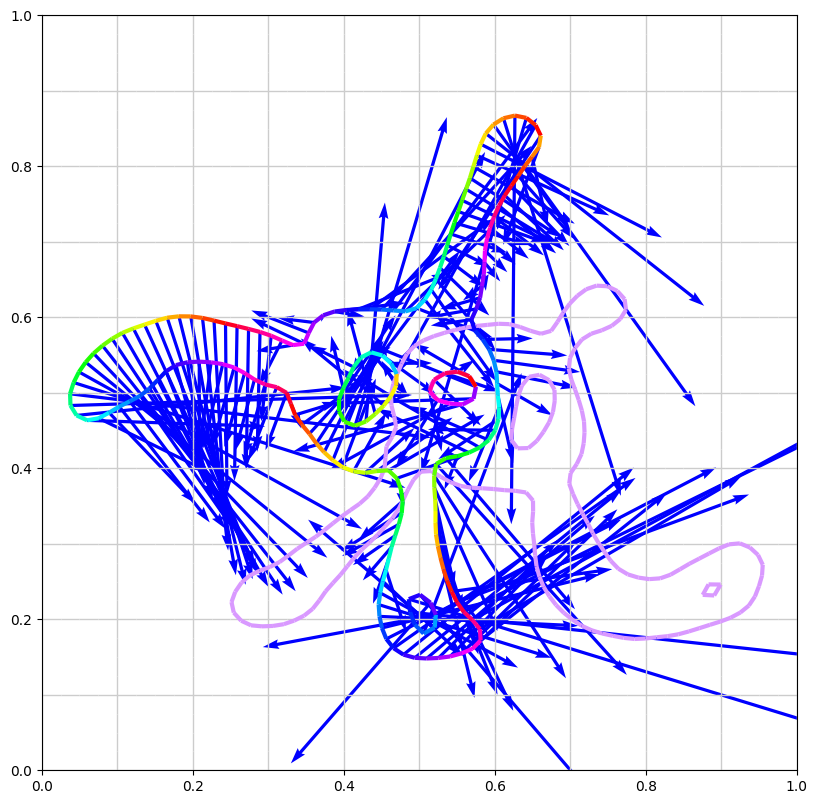

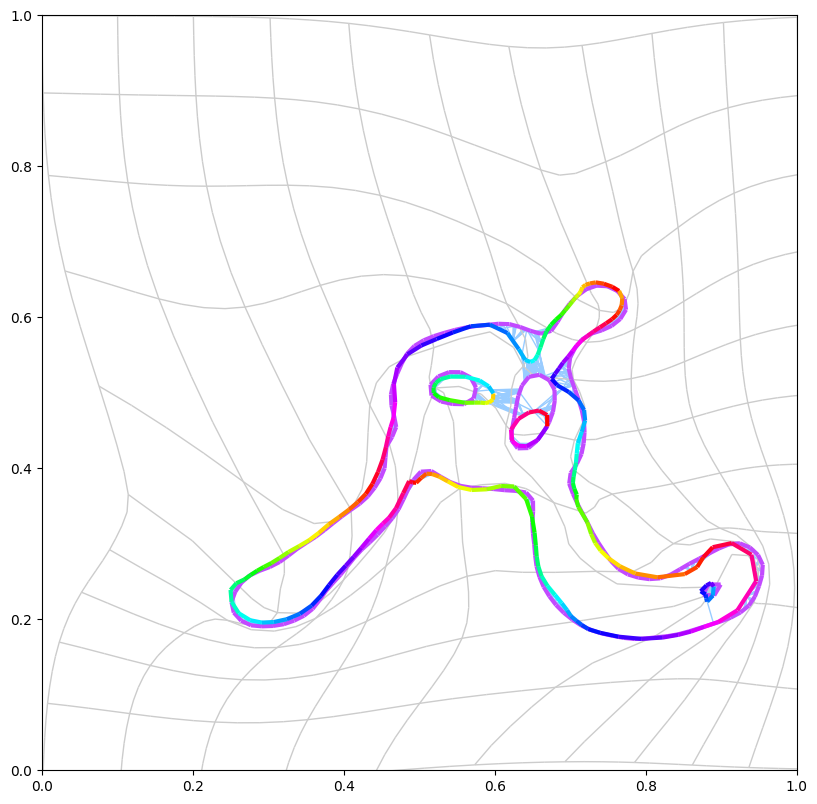

Iteration :  40 , cost :  0.0024100626  info :  (198, 198)
Sinkhorn error after 270 iterations : 9.894685e-05
Iteration :  41 , cost :  0.0024001347  info :  (198, 198)
Sinkhorn error after 272 iterations : 9.9917466e-05
Iteration :  42 , cost :  0.0023759094  info :  (198, 198)
Sinkhorn error after 242 iterations : 9.850832e-05
Iteration :  43 , cost :  0.002389621  info :  (198, 198)
Sinkhorn error after 260 iterations : 9.973312e-05
Iteration :  44 , cost :  0.0023560966  info :  (198, 198)
Sinkhorn error after 274 iterations : 9.982998e-05
Iteration :  45 , cost :  0.0023445452  info :  (198, 198)
Sinkhorn error after 269 iterations : 9.8700635e-05
Iteration :  46 , cost :  0.002334518  info :  (198, 198)
Sinkhorn error after 268 iterations : 9.97443e-05
Iteration :  47 , cost :  0.0023265705  info :  (198, 198)
Sinkhorn error after 269 iterations : 9.990088e-05
Iteration :  48 , cost :  0.0023199825  info :  (198, 198)
Sinkhorn error after 285 iterations : 9.97892e-05
Iteration : 

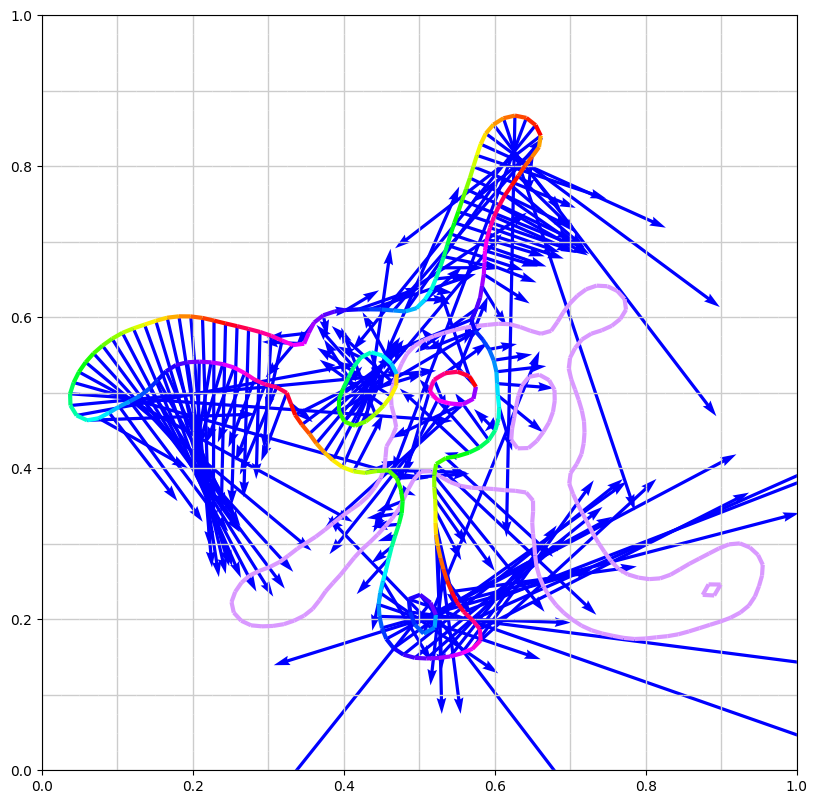

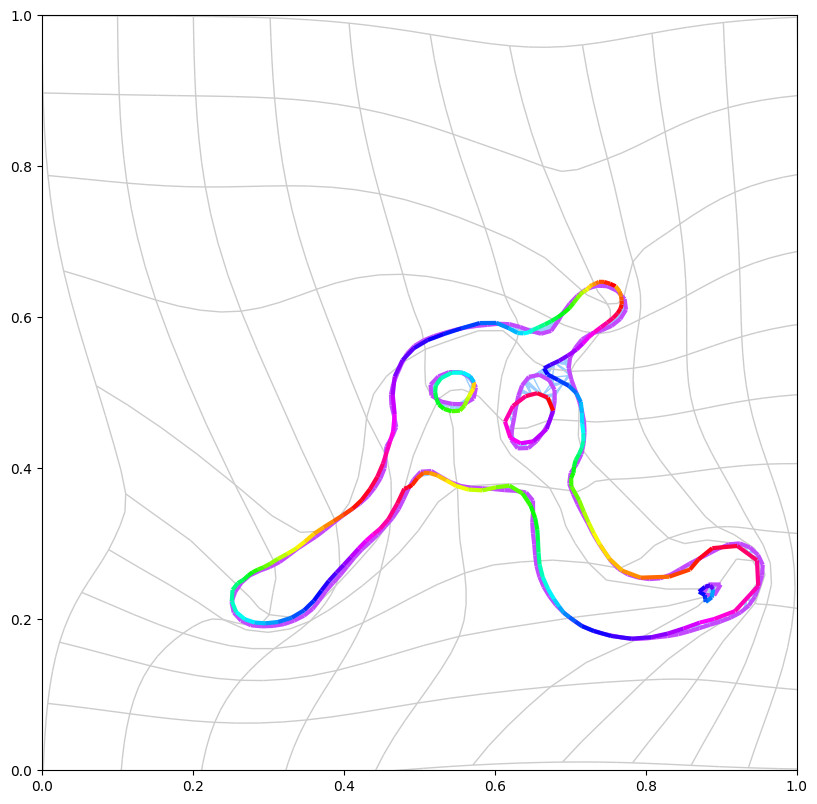

Iteration :  60 , cost :  0.0022490232  info :  (198, 198)
Sinkhorn error after 266 iterations : 9.953184e-05
Iteration :  61 , cost :  0.002245413  info :  (198, 198)
Sinkhorn error after 267 iterations : 9.923149e-05
Iteration :  62 , cost :  0.002242999  info :  (198, 198)
Sinkhorn error after 270 iterations : 9.894231e-05
Iteration :  63 , cost :  0.0022457775  info :  (198, 198)
Sinkhorn error after 272 iterations : 9.858073e-05
Iteration :  64 , cost :  0.0022373125  info :  (198, 198)
Sinkhorn error after 272 iterations : 9.981869e-05
Iteration :  65 , cost :  0.0022358017  info :  (198, 198)
Sinkhorn error after 275 iterations : 9.83614e-05
Iteration :  66 , cost :  0.002233515  info :  (198, 198)
Sinkhorn error after 276 iterations : 9.858748e-05
Iteration :  67 , cost :  0.0022317974  info :  (198, 198)
Sinkhorn error after 279 iterations : 9.9679455e-05
Iteration :  68 , cost :  0.0022309017  info :  (198, 198)
Sinkhorn error after 279 iterations : 9.9679455e-05
Iteration : 

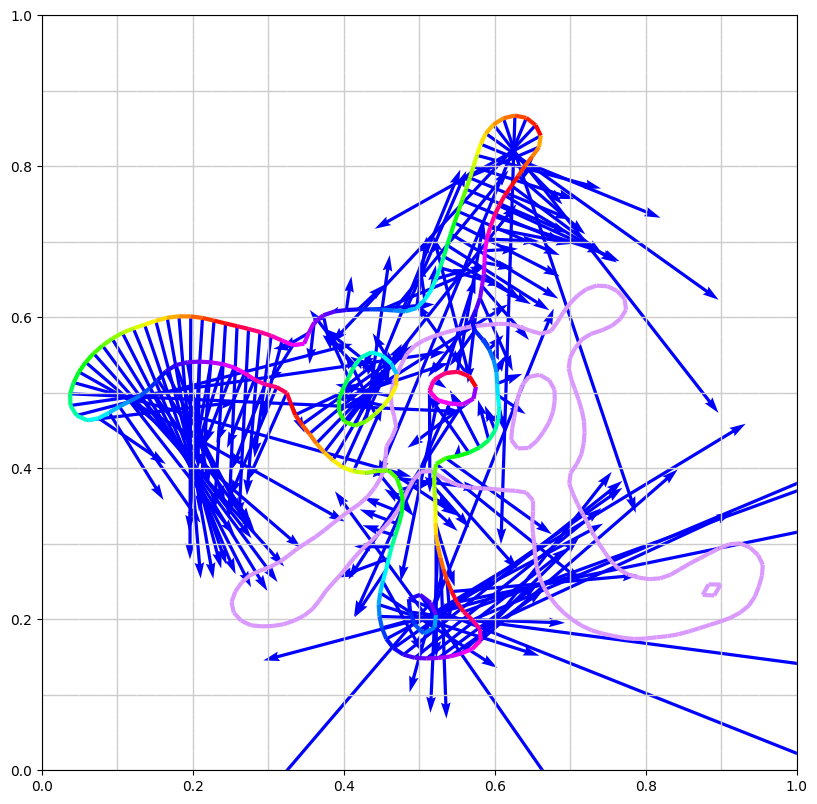

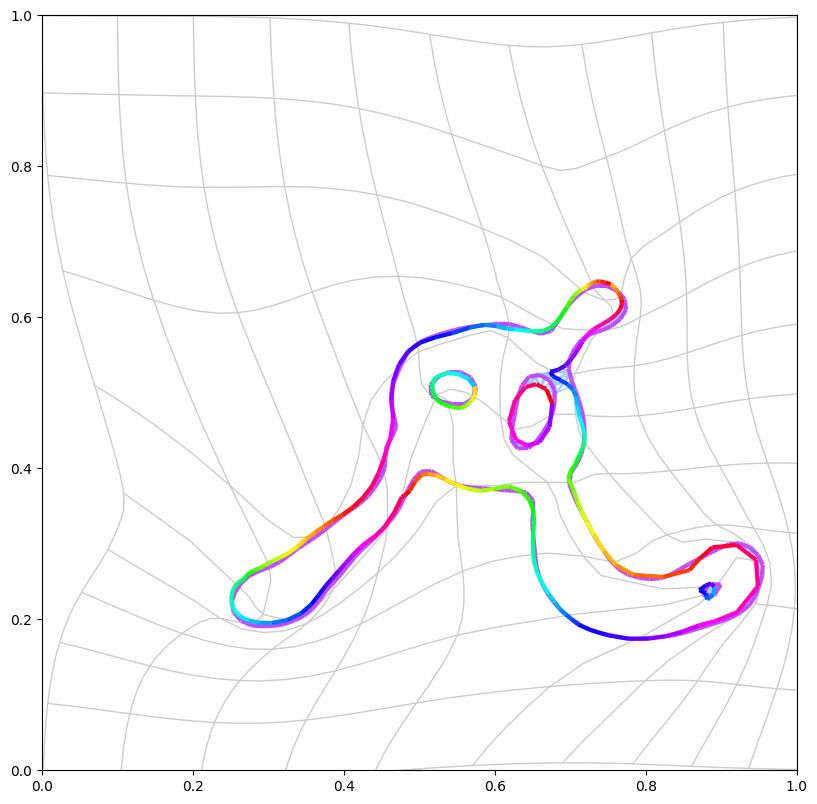

Iteration :  80 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  81 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  82 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  83 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  84 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  85 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  86 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  87 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  88 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  89 , cost :  0.

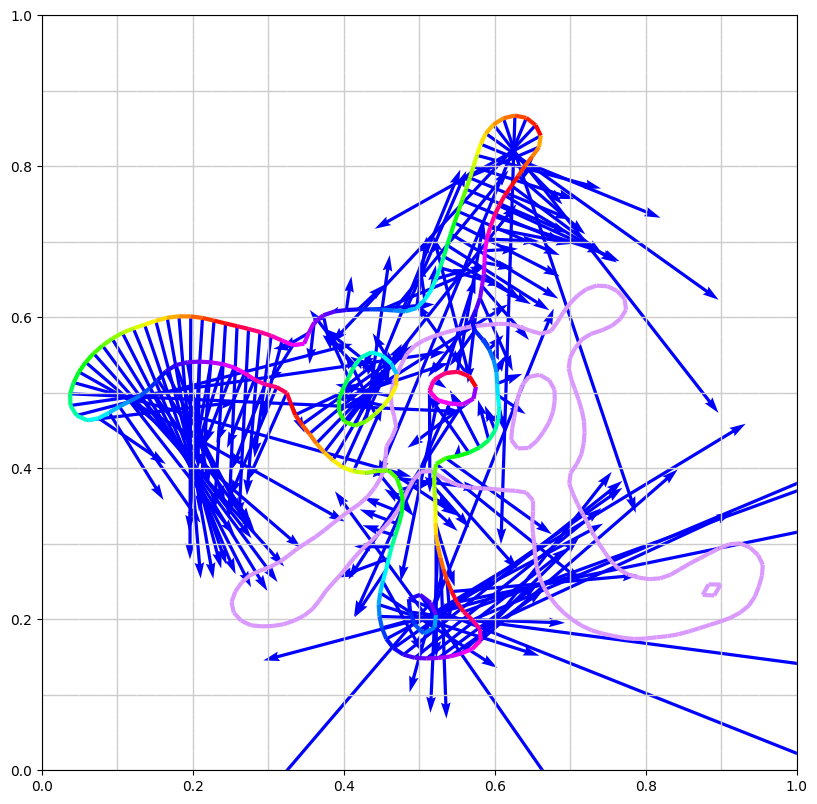

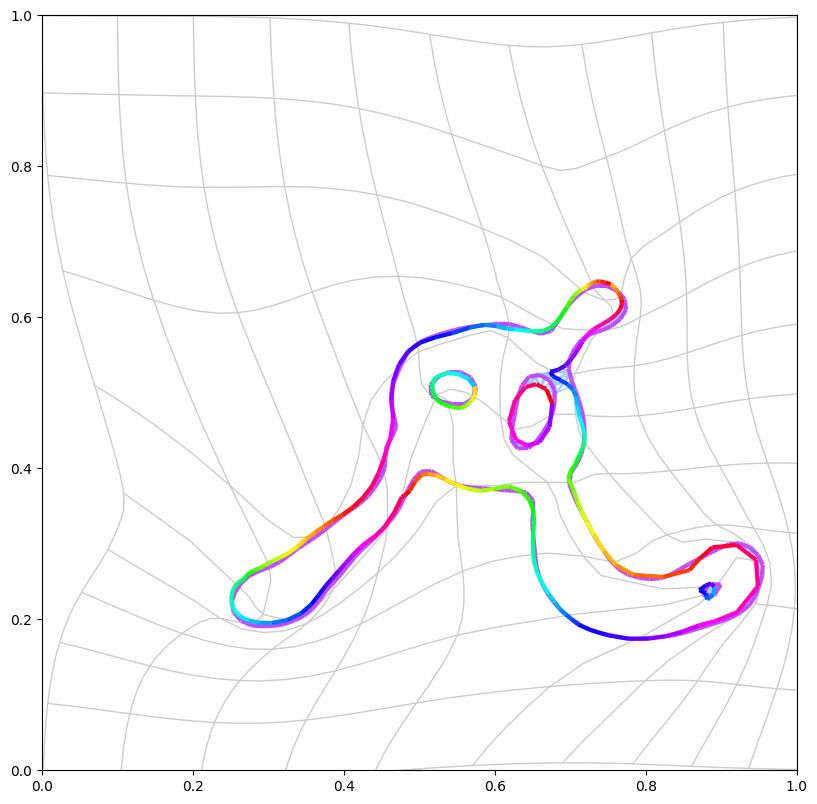

Iteration :  100 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  101 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  102 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  103 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  104 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  105 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  106 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  107 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  108 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  109 , 

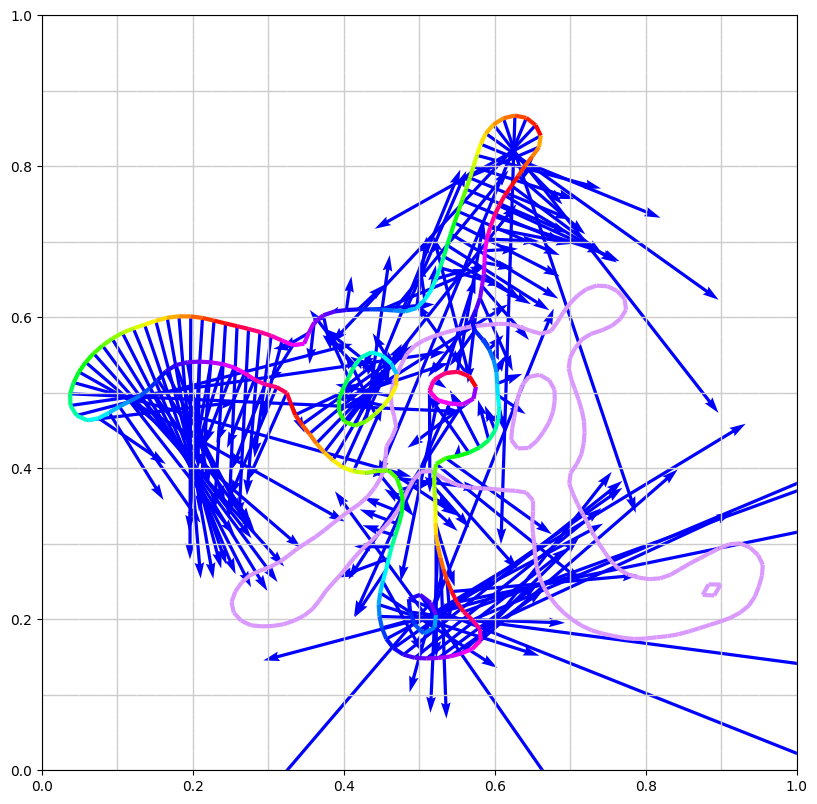

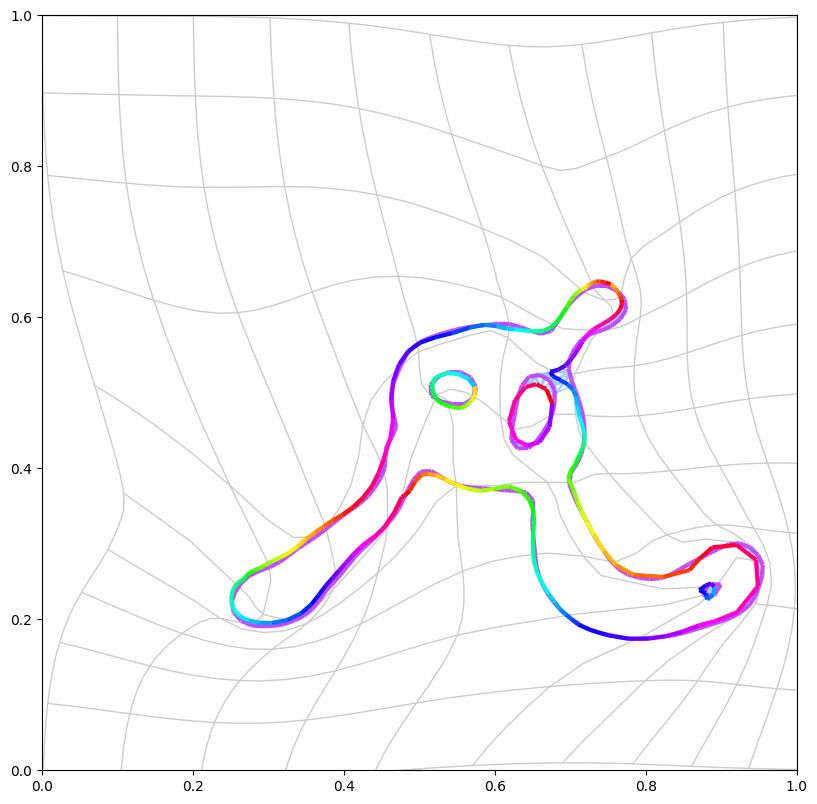

Iteration :  120 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  121 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  122 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  123 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  124 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  125 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  126 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  127 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  128 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  129 , 

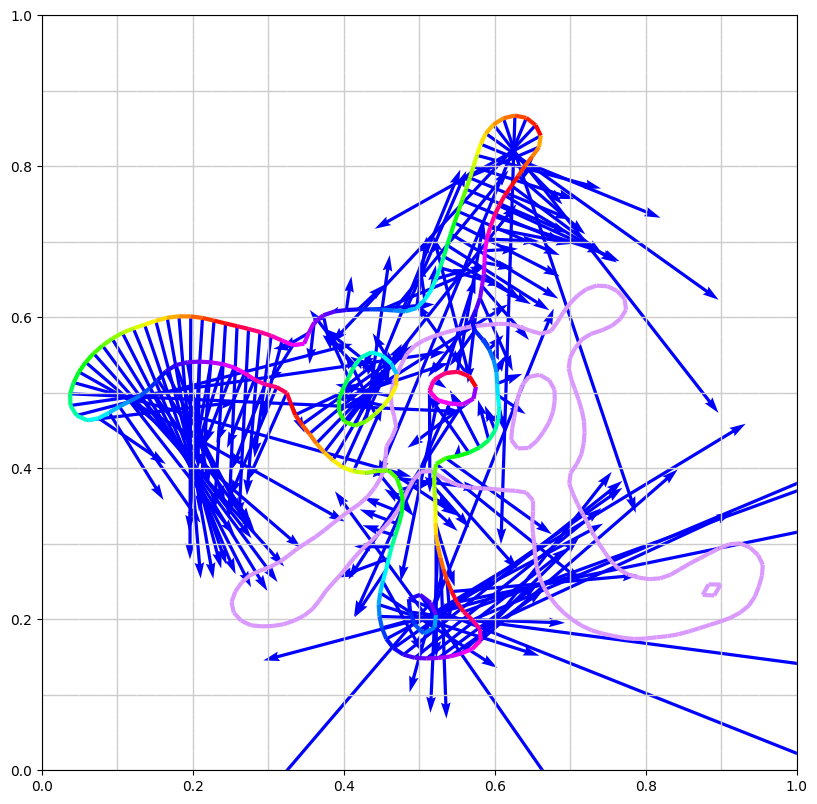

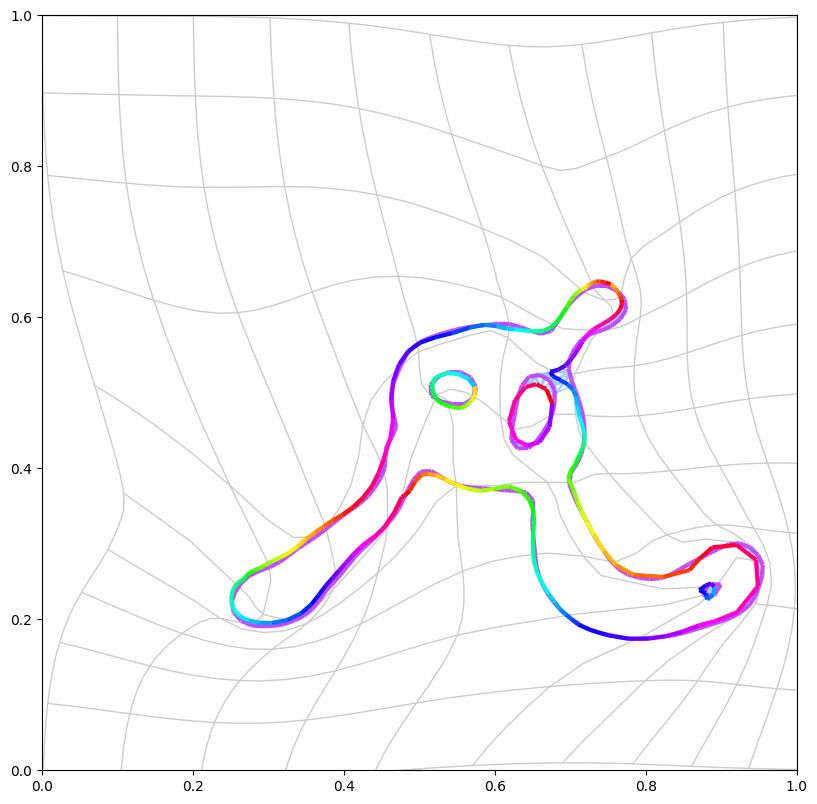

Iteration :  140 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  141 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  142 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  143 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  144 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  145 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  146 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  147 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  148 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  149 , 

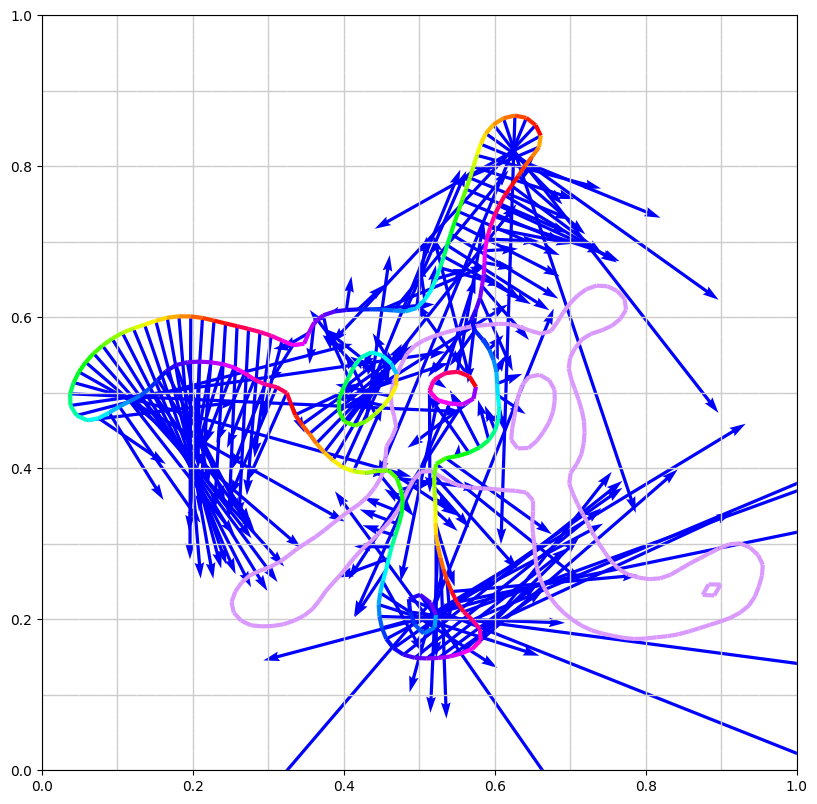

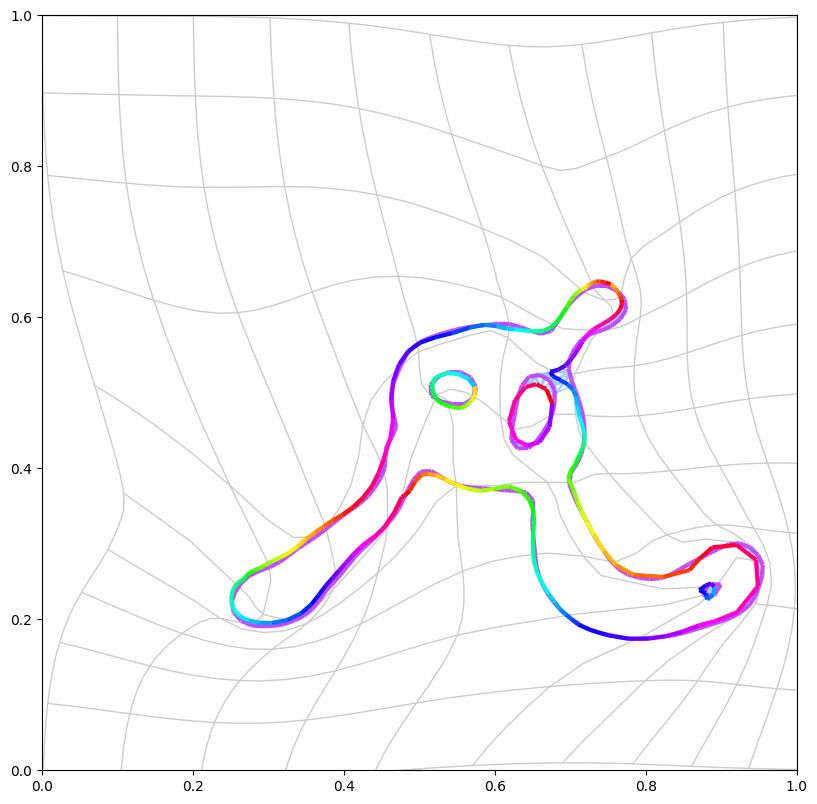

Iteration :  160 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  161 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  162 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  163 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  164 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  165 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  166 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  167 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  168 , cost :  0.00221306  info :  (198, 198)
Sinkhorn error after 282 iterations : 9.840261e-05
Iteration :  169 , 

In [33]:
# (scale, radius) if radius=0 uses OT data 
# (σ for rbf kernel for hamiltonian comtric, 
#  σ for rbf kernel if use MMD as data matching term)
params = (.1,0)
# scaling to quiver plot to display vector fields
scale_momentum = .05
# 0 for using ot
scale_attach = 0

f1_name = 'data/amoeba_1.png'
f2_name = 'data/amoeba_2.png'

# level_curve_kwargs = {'smoothing': .3, 'level': .5}
# f1_name = 'data/bone.png'
# f2_name = 'data/bottle.png'

Q0 = Curve.from_file(f1_name)
Xt = Curve.from_file(f2_name)


fig, axs = plt.subplots(1,2,figsize=(10,5))
Q0.plot(axs[0])
Xt.plot(axs[1])



"Performs a matching from the source Q0 to the target Xt, returns the optimal momentum P0."
(Xt_x, Xt_mu) = Xt.to_measure()      # Transform the target into a measure once and for all
connec = torch.from_numpy(Q0.connectivity).type(dtypeint) ; 
# Compilation -------------------------------------------------------------------------------
# Cost is a function of 6 parameters :
# The source 'q',                    the starting momentum 'p',
# the target points 'xt_x',          the target weights 'xt_mu',
# the deformation scale 'sigma_def', the attachment scale 'sigma_att'.
q0    = Variable(torch.from_numpy(    Q0.points ).type(dtype), requires_grad=True)
p0    = Variable(torch.from_numpy( 0.*Q0.points ).type(dtype), requires_grad=True )
Xt_x  = Variable(torch.from_numpy( Xt_x         ).type(dtype), requires_grad=False)
Xt_mu = Variable(torch.from_numpy( Xt_mu        ).type(dtype), requires_grad=False)

# Compilation. Depending on settings specified in the ~/.theanorc file or explicitely given
# at execution time, this will produce CPU or GPU code under the hood.
def Cost(q,p, xt_x,xt_mu) : 
    return _cost( q,p, (xt_x,xt_mu), connec, params )

# Display pre-computing ---------------------------------------------------------------------
g0,cgrid = GridData() ; G0 = Curve(g0, cgrid )
g0 = Variable( torch.from_numpy( g0 ).type(dtype), requires_grad = False )
# Given q0, p0 and grid points grid0 , outputs (q1,p1,grid1) after the flow
# of the geodesic equations from t=0 to t=1 :
ShootingVisualization = VisualizationRoutine(q0, params) 

# L-BFGS minimization -----------------------------------------------------------------------
from scipy.optimize import minimize
def matching_problem(p0) :
    "Energy minimized in the variable 'p0'."
    [c, info] = Cost(q0, p0, Xt_x, Xt_mu)

    matching_problem.Info = info
    if (matching_problem.it % 20 == 0):# and (c.data.cpu().numpy()[0] < matching_problem.bestc):

        matching_problem.bestc = c.data.cpu().numpy()
        q1,p1,g1 = ShootingVisualization(q0, p0, g0)

        q1 = q1.data.cpu().numpy()
        p1 = p1.data.cpu().numpy()
        g1 = g1.data.cpu().numpy()

        Q1 = Curve(q1, connec) ; G1 = Curve(g1, cgrid )
        DisplayShoot( Q0, G0,       p0.data.cpu().numpy(), 
                      Q1, G1, Xt, info.data.cpu().numpy(),
                      matching_problem.it, scale_momentum, scale_attach)

    print('Iteration : ', matching_problem.it, ', cost : ', c.data.cpu().numpy(), 
                                                ' info : ', info.data.cpu().numpy().shape)
    matching_problem.it += 1
    return c

matching_problem.bestc = np.inf ; matching_problem.it = 0 ; matching_problem.Info = None

optimizer = torch.optim.LBFGS(
                [p0],
                max_iter = 1000, 
                tolerance_change = .000001, 
                history_size = 10)
# optimizer = torch.optim.Adam([p0])
time1 = time.time()
def closure():
    optimizer.zero_grad()
    c = matching_problem(p0)
    c.backward()
    return c
for it in range(100) :
    optimizer.step(closure)
time2 = time.time()






IndexError: index 197 is out of bounds for axis 0 with size 197

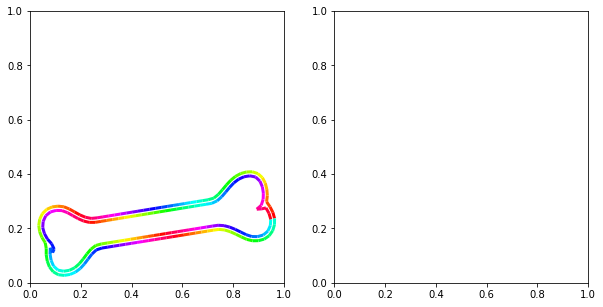

In [291]:

level_curve_kwargs = {'smoothing': .6, 'level': .5}
f1_name = 'data/bone.png'
f2_name = 'data/bottle.png'

Q0 = Curve.from_file(f1_name,**level_curve_kwargs)
Xt = Curve.from_file(f2_name,**level_curve_kwargs)


fig, axs = plt.subplots(1,2,figsize=(10,5))
Q0.plot(axs[0])
Xt.plot(axs[1])

In [251]:
length

array([0.01550903, 0.01556287, 0.01552331, 0.01559686, 0.01561951,
       0.01562176, 0.01565356, 0.01568024, 0.0156814 , 0.01568144,
       0.01568044, 0.01568132, 0.0156816 , 0.01568154, 0.01568061,
       0.01568162, 0.01568159, 0.01567906, 0.0156815 , 0.01566925,
       0.01566291, 0.01561143, 0.01544704, 0.01567109, 0.01567803,
       0.01568068, 0.01568144, 0.01567838, 0.01567445, 0.01562495,
       0.01559015, 0.01554762, 0.01547767, 0.01490459, 0.01567193,
       0.01568067, 0.01567316, 0.01568112, 0.01568136, 0.01568157,
       0.01568159, 0.01568024, 0.01566827, 0.01567616, 0.01566077,
       0.01567512, 0.01568151, 0.01568137, 0.01567505, 0.01566657,
       0.01567948, 0.01566879, 0.01567419, 0.01566751, 0.01567143,
       0.01564772, 0.01554197, 0.01549405, 0.01539395, 0.01552826,
       0.01566289, 0.01567978, 0.01567819, 0.01566835, 0.0156604 ,
       0.01567679, 0.01567362, 0.01559649, 0.01564182, 0.01566845,
       0.01567604, 0.0156747 , 0.01566027, 0.01565927, 0.01568